In [33]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import os
import zipfile # Import the zipfile module

zip_file_path = "/content/PlantVillage.Zip.zip"

# Check if the file exists before trying to open it
if os.path.exists(zip_file_path):
    # Open the zip file and list its contents
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        print(zip_ref.namelist()) # Use namelist() to see contents of the zip file
else:
    print(f"Error: The file {zip_file_path} was not found.")

['PlantVillage/', 'PlantVillage/Potato___Early_blight/', 'PlantVillage/Potato___Early_blight/001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG', 'PlantVillage/Potato___Early_blight/002a55fb-7a3d-4a3a-aca8-ce2d5ebc6925___RS_Early.B 8170.JPG', 'PlantVillage/Potato___Early_blight/009c8c31-f22d-4ffd-8f16-189c6f06c577___RS_Early.B 7885.JPG', 'PlantVillage/Potato___Early_blight/00d8f10f-5038-4e0f-bb58-0b885ddc0cc5___RS_Early.B 8722.JPG', 'PlantVillage/Potato___Early_blight/0182e991-97f0-4805-a1f7-6e1b4306d518___RS_Early.B 7015.JPG', 'PlantVillage/Potato___Early_blight/02578b86-b234-4ac0-9bc3-691b5610e2bf___RS_Early.B 7562.JPG', 'PlantVillage/Potato___Early_blight/0267d4ca-522e-4ca0-b1a2-ce925e5b54a2___RS_Early.B 7020.JPG', 'PlantVillage/Potato___Early_blight/028f9b73-142f-499a-9c7b-d7c1ed5e5506___RS_Early.B 8546.JPG', 'PlantVillage/Potato___Early_blight/034959c1-f1e8-4a79-a6d5-3c1d14efa2f3___RS_Early.B 7136.JPG', 'PlantVillage/Potato___Early_blight/03b0d3c1-b5b0-48f4-98aa-f890467029

In [38]:
Batch_Size=32
Image_Size=256
Channels=3
Epochs=50

In [35]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage/PlantVillage",
    shuffle=True,
    image_size=(Image_Size, Image_Size),
    batch_size=Batch_Size
)


Found 2152 files belonging to 3 classes.


In [36]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

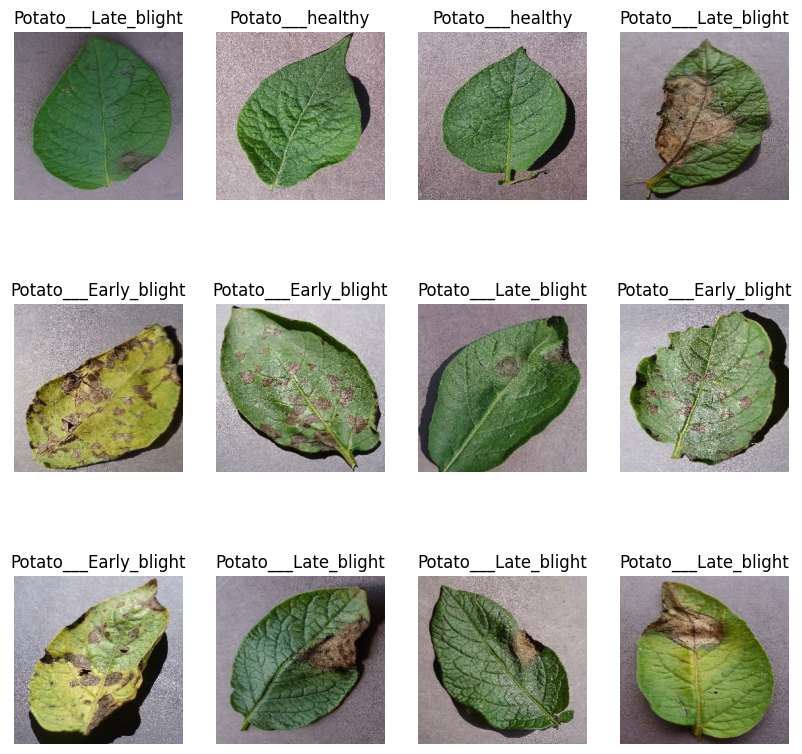

In [37]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
  for i in range(12):
    ax=plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

In [39]:
# splittinf the dataset into train data, test data and validation data
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
  ds_size=len(ds)

  if shuffle:
    ds=ds.shuffle(shuffle_size,seed=12)

    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [40]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [41]:
len(train_ds)

54

In [42]:
len(val_ds)

6

In [43]:
len(test_ds)

8

In [44]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [49]:
resize_and_rescale=tf.keras.Sequential([
    tf.keras.layers.Resizing(Image_Size,Image_Size),
    tf.keras.layers.Rescaling(1.0/255)
])

In [50]:
data_augmentation= tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2)
])

In [52]:
# Build A Model
input_shape=(Batch_Size,Image_Size,Image_Size,Channels)
n_classes=3

model=models.Sequential([
    resize_and_rescale,data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),

])
model.build(input_shape=input_shape)

In [53]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [56]:
training_process=model.fit(
    train_ds,
    epochs=Epochs,
    batch_size=Batch_Size,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 266s 5s/step - accuracy: 0.4452 - loss: 0.9628 - val_accuracy: 0.5000 - val_loss: 0.8296
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 242s 4s/step - accuracy: 0.5726 - loss: 0.8384 - val_accuracy: 0.7604 - val_loss: 0.5789
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 245s 5s/step - accuracy: 0.7485 - loss: 0.5532 - val_accuracy: 0.8281 - val_loss: 0.5799
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 250s 5s/step - accuracy: 0.7599 - loss: 0.5420 - val_accuracy: 0.8802 - val_loss: 0.3310
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 252s 5s/step - accuracy: 0.8390 - loss: 0.3855 - val_accuracy: 0.9062 - val_loss: 0.2957
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 263s 5s/step - accuracy: 0.8640 - loss: 0.3045 - val_accuracy: 0.9010 - val_loss: 0.1769
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 241s 4s/step - accuracy: 0.9018 - loss: 0.2307 - val_accuracy: 0.9323 - val_loss: 0.1516
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 258s 5s/step - accuracy: 0.9188 - loss: 0.2372 - val_accuracy: 0.9531 - v

In [57]:
training_process.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [58]:
training_process.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

Text(0.5, 1.0, 'Training and Validation Accuracy')

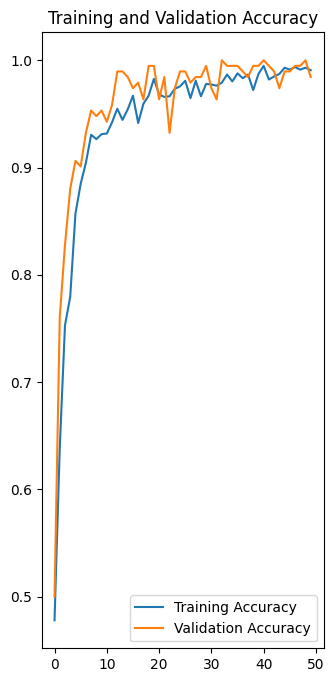

In [60]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
# Access the training accuracy from the history object
acc = training_process.history['accuracy']
# Access the validation accuracy from the history object
val_acc = training_process.history['val_accuracy']
plt.plot(range(Epochs), acc, label='Training Accuracy')
plt.plot(range(Epochs), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

first image to predict
actual label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
predicted label: Potato___Late_blight


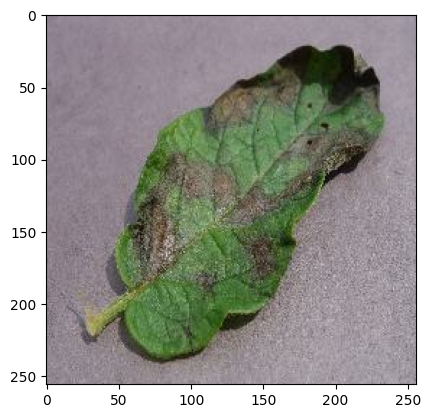

In [62]:
import numpy as np
for image_batch,label_batch in test_ds.take(1):
  first_image=image_batch[0].numpy ().astype('uint8')
  first_label=label_batch[0].numpy()

  print('first image to predict')
  plt.imshow(first_image)
  print('actual label:',class_names[first_label])

  batch_prediction=model.predict(image_batch)
  print('predicted label:',class_names[np.argmax(batch_prediction[0])])

In [63]:
def predict(model, img):
  img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array=tf.expand_dims(img_array,0) # create a batch

  prediction=model.predict(img_array)

  predicted_class=class_names[np.argmax(prediction[0])]
  confidence=round(100*(np.max(prediction[0])),2)
  return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


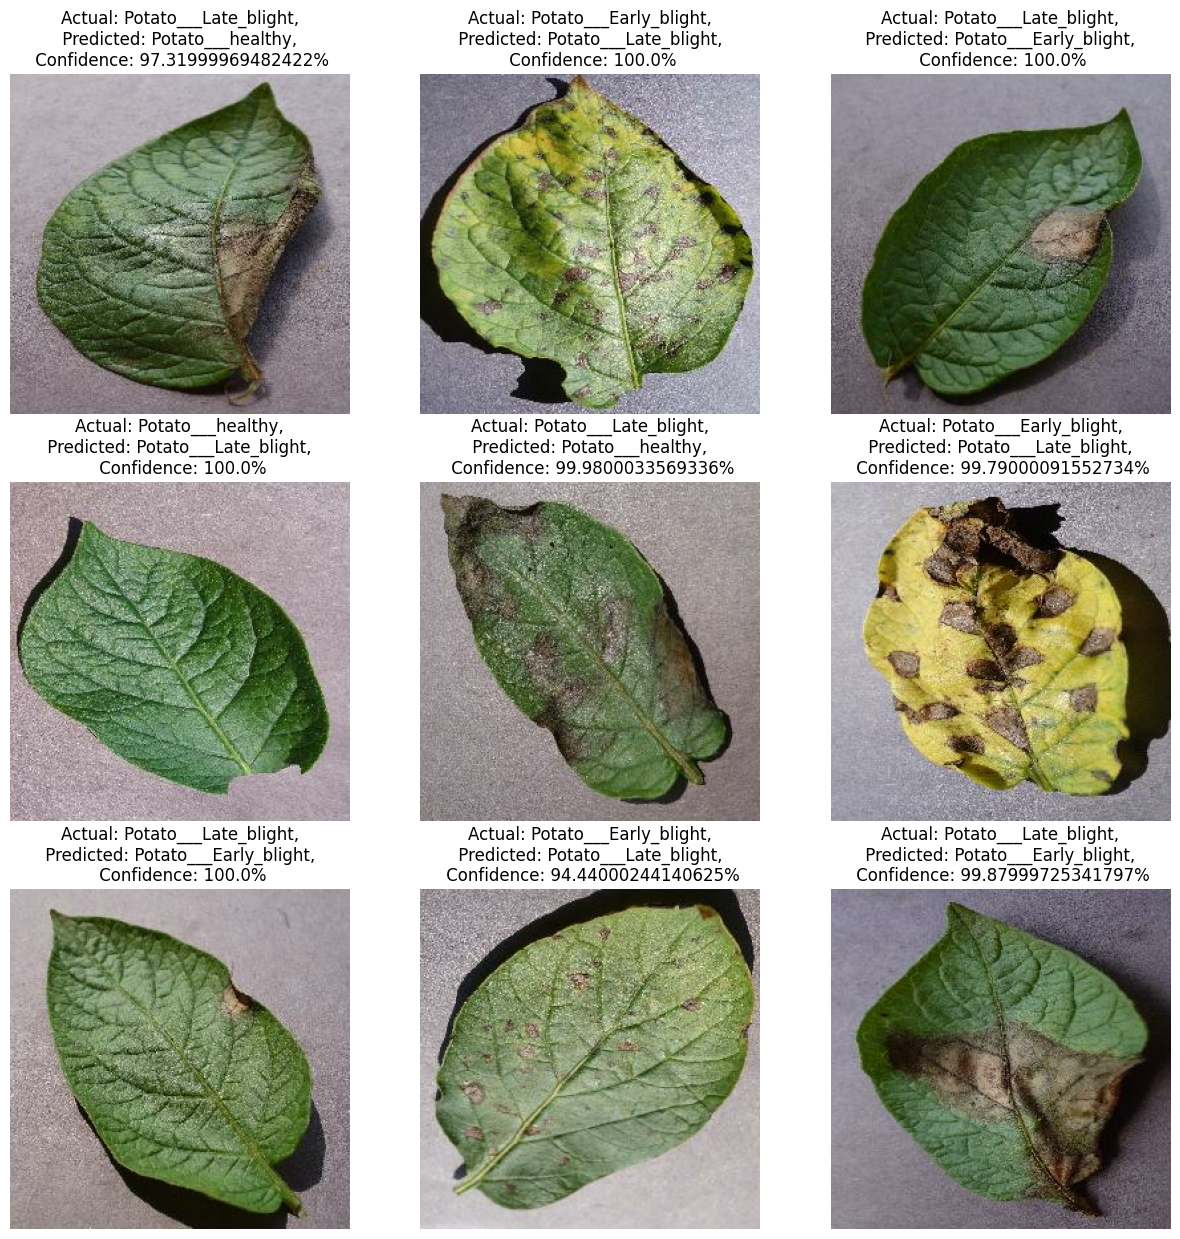

In [66]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
  for i in range(9):
    ax=plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))
    actual_class=class_names[labels[i]]

    plt.title(f'Actual: {actual_class},\n Predicted: {predicted_class}, \n Confidence: {confidence}%')

    predicted_class,confidence=predict(model, images[i].numpy())
    plt.axis('off')